### Step 1.1 — Baseline: All Features → StandardScaler

In this baseline setup, all **original features** from the MAGIC dataset are used without transformation.  
Each feature is standardized using **`StandardScaler`**, ensuring zero mean and unit variance.  
No log transformations or dimensionality reduction are applied.

**Workflow:**
1. Load all features (`fLength` → `fDist`, `class`).
2. Apply **StandardScaler** to normalize feature scales.
3. Train and compare models using 5-fold Stratified CV with **pAUC@≤0.10** as the selection metric.
4. Evaluate models on the test set using:
   - **TPR at FPR = 0.01, 0.02, 0.05, 0.10, 0.20**
   - **Partial AUCs**, **Full AUC**, and **Confusion Matrix**
   - **ROC curves** and an **overlay plot** for all models

**Models used:**  
Decision Tree, Random Forest, RBF-SVM, Gradient Boosting (GBDT), MLP, and XGBoost.

**Goal:**  
Establish a baseline low-FPR performance using all standardized features before introducing log transforms or PCA.


In [1]:
# ===============================================================
# Full script: DT, RF, XGB, LGBM, RBF-SVM, GBDT, MLP
# with CV, low-FPR metrics, upsampling (resample), and ordered tables
# Confusion Matrix labels set to 'g' and 'h'
# ===============================================================

import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass, field
from typing import Dict, Tuple, List

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

_XGB_AVAILABLE = True
try:
    from xgboost import XGBClassifier
except Exception:
    _XGB_AVAILABLE = False

# Try to enable nice tabular printing
_HAVE_TABULATE = False
try:
    from tabulate import tabulate
    _HAVE_TABULATE = True
except Exception:
    _HAVE_TABULATE = False


In [2]:
# --------------------- Load data exactly as you described ---------------------
CSV_PATH = "./magic04_gamma.csv"  # <- set your path if needed
df = pd.read_csv(CSV_PATH)

columns = [
    "fLength", "fWidth", "fSize", "fConc", "fConc1",
    "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"
]

# Feature matrix (all but last) & labels (last)
X = df[columns[:-1]].values
y = df[columns[-1]].values  # array of 'g'/'h'

# Standardize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y distribution (train):", pd.Series(y_train).value_counts().to_dict())
print("y distribution (test):", pd.Series(y_test).value_counts().to_dict())

# --------------------- Upsample minority class (global, before CV) ---------------------
print("\nBefore upsampling (train):")
print(pd.Series(y_train).value_counts())

train_df = pd.DataFrame(X_train)
train_df["label"] = y_train

# Identify majority/minority
majority_class = train_df["label"].value_counts().idxmax()
minority_class = train_df["label"].value_counts().idxmin()

df_majority = train_df[train_df["label"] == majority_class]
df_minority = train_df[train_df["label"] == minority_class]

df_minority_upsampled = resample(
    df_minority, replace=True, n_samples=len(df_majority), random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled], axis=0)
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = df_upsampled.drop(columns=["label"]).values
y_train = df_upsampled["label"].values

print("\nAfter upsampling (train):")
print(pd.Series(y_train).value_counts())




X_train: (15216, 10) X_test: (3804, 10)
y distribution (train): {'g': 9866, 'h': 5350}
y distribution (test): {'g': 2466, 'h': 1338}

Before upsampling (train):
g    9866
h    5350
Name: count, dtype: int64

After upsampling (train):
h    9866
g    9866
Name: count, dtype: int64


In [3]:
# --------------------- ROC-focused multi-model suite ---------------------

@dataclass
class ROCFocusedClassifierSuite:
    """
    Multi-model suite with 5-fold CV + small randomized search.
    Positive (signal) is 'g'; negative (background) is 'h'.

    For EACH best-tuned model:
      - prints best params + metrics
      - shows Confusion Matrix (labeled 'h','g') + ROC with TPR markers at FPR ∈ {0.01, 0.02, 0.05, 0.10, 0.20}
    Finally:
      - overlays ROC curves of all best-tuned models for comparison
      - prints tables with columns ordered from lowest thresholds → AUC (full)
    """
    X_train: np.ndarray
    y_train: np.ndarray    # strings: 'g'/'h'
    X_test: np.ndarray
    y_test: np.ndarray     # strings: 'g'/'h'
    positive_label: str = "g"
    fpr_targets: Tuple[float, ...] = (0.01, 0.02, 0.05, 0.10, 0.20)
    selection_max_fpr: float = 0.10
    n_iter: int = 6        # small grid for speed; increase for thorough search
    cv_splits: int = 5
    n_jobs: int = -1
    random_state: int = 42
    verbose: int = 0

    results_: Dict[str, dict] = field(default_factory=dict, init=False)
    best_name_: str = field(default=None, init=False)

    def run_and_report(self) -> pd.DataFrame:
        self._prepare_labels()
        models = self._build_models()

        # Fit & evaluate each model; store test ROC for overlay
        for name, (clf, param_dist) in models.items():
            search = self._fit_with_cv(name, clf, param_dist)
            metrics = self._evaluate_on_test(search.best_estimator_)
            self.results_[name] = {
                "search": search,
                "cv_best_score": float(search.best_score_),
                "best_params": search.best_params_,
                **metrics,
            }
            # Per-model report & plots
            self._print_model_report(name, self.results_[name])
            self._plot_confusion_and_roc(self.results_[name], title_prefix=f"{name} — ")

        # Pick best by CV partial AUC
        self.best_name_ = max(self.results_, key=lambda k: self.results_[k]["cv_best_score"])
        
        # -------- Select BEST by highest TEST pAUC@≤0.10 --------
        # pauc_key = "0.10"
        # if pauc_key not in [f"{t:.2f}" for t in self.fpr_targets]:
        #     raise ValueError("fpr_targets must include 0.10 to select best by pAUC@≤0.10.")
        # self.best_name_ = max(self.results_, key=lambda k: self.results_[k]["pAUCs"][pauc_key])
        # best = self.results_[self.best_name_]
        # print(f"\nSelected BEST model by test-set pAUC@≤0.10: {self.best_name_} "
        #       f"(pAUC={best['pAUCs'][pauc_key]:.4f})")

        # Save best model's Confusion Matrix & ROC plots
        # self._save_best_plots(best_res=best, out_dir="plots", prefix=self.best_name_)
        

        # Overlay ROC of all best-tuned models
        self._plot_all_rocs()

        # Summary table (DataFrame) + pretty print in requested order
        summary = self._build_summary_table()
        self._print_tabular_summary(summary)
        return summary

    # ------------ internals ------------
    def _prepare_labels(self):
        y_tr = np.asarray(self.y_train)
        y_te = np.asarray(self.y_test)
        classes = np.unique(np.concatenate([y_tr, y_te]))
        if self.positive_label not in classes or len(classes) != 2:
            raise ValueError(f"Expected two classes including '{self.positive_label}'. Found: {classes}")
        # positive=1 ('g'), negative=0 ('h')
        self.y_train_enc_ = (y_tr == self.positive_label).astype(int)
        self.y_test_enc_  = (y_te == self.positive_label).astype(int)

    def _build_models(self) -> Dict[str, Tuple[object, dict]]:
        rs = self.random_state
        models = {}

        # ---------------- Decision Tree ----------------
        dt = DecisionTreeClassifier(random_state=rs)
        dt_params = {
            "max_depth": [None, 5, 10, 15, 20, 50],
            "min_samples_split": [2, 5, 10, 20],
            "min_samples_leaf": [1, 2, 5, 10, ],
            "max_features": [None, "sqrt", "log2"]            
        }
        models["DecisionTree"] = (dt, dt_params)

        # ---------------- Random Forest ----------------
        rf = RandomForestClassifier(random_state=rs, n_estimators=200, n_jobs=self.n_jobs)
        rf_params = {
            "n_estimators": [50, 100, 150, 200, 500],
            "max_depth": [None, 10, 20, 50],
            "min_samples_split": [2, 5, 10, 20],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_features": ["sqrt", "log2"],
        }
        models["RandomForest"] = (rf, rf_params)

        # ---------------- RBF SVM ----------------
        # (features are already standardized + PCA'ed above)
        svm = SVC(kernel="rbf", probability=True)  # SVC has no 'random_state' param
        svm_params = {
            "C": [1, 5, 10, 50, 100],
            "gamma": ["scale", "auto", 0.3, 0.1, 0.03, 0.01],
        }
        models["SVM_RBF"] = (svm, svm_params)

        # ---------------- GBDT (Gradient Boosting) ----------------
        gbdt = GradientBoostingClassifier(random_state=rs)
        gbdt_params = {
            "n_estimators": [100, 200, 500],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.5, 0.8, 1.0],
            "max_features": [None, "sqrt", "log2"],
        }
        models["GBDT"] = (gbdt, gbdt_params)

        # ---------------- MLP (Neural Net) ----------------
        mlp = MLPClassifier(random_state=rs, early_stopping=True, max_iter=400)
        mlp_params = {
            "hidden_layer_sizes": [(64,), (128,), (256,), (128, 64), (256, 128)],
            "activation": ["relu", "tanh"],
            "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
            "learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
            "batch_size": [64, 128, 256]
            
        }
        models["MLP"] = (mlp, mlp_params)

        # ---------------- XGBoost (optional) ----------------
        if _XGB_AVAILABLE:
            xgb = XGBClassifier(
                random_state=rs,
                eval_metric="logloss",
                tree_method="hist",
                n_estimators=300,
                use_label_encoder=False,
            )
            xgb_params = {
                "n_estimators": [100, 200, 300, 500],
                "max_depth": [3, 5],
                "learning_rate": [0.01, 0.05, 0.1],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0],
                "min_child_weight": [1, 3, 5],
                "gamma": [0, 1],
                "reg_lambda": [0, 1, 10],
                "reg_alpha": [0, 0.01, 0.1]
                
            }
            models["XGBoost"] = (xgb, xgb_params)
        else:
            print("Note: xgboost not installed; skipping XGBoost.")
       
        return models

    def _fit_with_cv(self, name: str, clf, param_dist: dict) -> RandomizedSearchCV:
        cv = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)

        def _pauc_scorer(estimator, X, y):
            proba = estimator.predict_proba(X)[:, 1]  # positive=1 ('g')
            return roc_auc_score(y, proba, max_fpr=self.selection_max_fpr)

        search = RandomizedSearchCV(
            estimator=clf,
            param_distributions=param_dist,
            n_iter=self.n_iter,
            scoring=_pauc_scorer,
            n_jobs=self.n_jobs,
            cv=cv,
            refit=True,
            random_state=self.random_state,
            verbose=self.verbose,
        )
        search.fit(self.X_train, self.y_train_enc_)
        return search

    def _evaluate_on_test(self, estimator) -> dict:
        y_score = estimator.predict_proba(self.X_test)[:, 1]
        y_pred = (y_score >= 0.5).astype(int)

        # Keep fixed order [0,1] == ['h','g'] for consistency
        cm = confusion_matrix(self.y_test_enc_, y_pred, labels=[0, 1])
        fpr, tpr, _ = roc_curve(self.y_test_enc_, y_score)  # pos_label=1 ('g')
        auc_full = roc_auc_score(self.y_test_enc_, y_score)

        # TPR at requested FPRs (linear interpolation on ROC) + partial AUCs
        tpr_at_fpr = {}
        for ft in self.fpr_targets:
            ft_clamped = min(max(ft, fpr.min()), fpr.max())
            tpr_at_fpr[f"{ft:.2f}"] = float(np.interp(ft_clamped, fpr, tpr))

        pauc_at = {f"{ft:.2f}": float(roc_auc_score(self.y_test_enc_, y_score, max_fpr=ft))
                   for ft in self.fpr_targets}

        return dict(
            confusion_matrix=cm,      # order rows/cols: ['h','g']
            fpr=fpr, tpr=tpr,
            auc_full=float(auc_full),
            TPR_at_FPR=tpr_at_fpr,
            pAUCs=pauc_at,
            y_score=y_score,
            estimator=estimator
        )

    # --------- reporting/plots ----------
    def _print_model_report(self, name: str, res: dict):
        print(f"\n=== {name}: treating '{self.positive_label}' as POSITIVE (signal) ===")
        print(f"CV best (partial AUC @ FPR ≤ {self.selection_max_fpr:.2f}): {res['cv_best_score']:.4f}")
        print("Best parameters:")
        for k, v in res["best_params"].items():
            print(f"  {k}: {v}")

        print("\nTest-set metrics:")
        print(f"AUC (full): {res['auc_full']:.4f}")
        for fpr_max, p_auc in res["pAUCs"].items():
            print(f"partial AUC @ FPR ≤ {fpr_max}: {p_auc:.4f}")
        for fpr_t, tpr_v in res["TPR_at_FPR"].items():
            print(f"TPR @ FPR = {fpr_t}: {tpr_v:.4f}")

        # Labeled confusion matrix: rows/cols ['h','g']
        cm_df = pd.DataFrame(res["confusion_matrix"], index=['h', 'g'], columns=['h', 'g'])
        print("\nConfusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:")
        print(cm_df)

    def _plot_confusion_and_roc(self, res: dict, title_prefix: str = ""):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Confusion Matrix with display labels 'h','g' (order matches labels=[0,1])
        y_pred = (res["y_score"] >= 0.5).astype(int)
        ConfusionMatrixDisplay.from_predictions(
            self.y_test_enc_, y_pred,
            labels=[0, 1],                # explicit order: 0='h', 1='g'
            display_labels=['h', 'g'],    # axis tick labels
            ax=axes[0], cmap="Blues", colorbar=False
        )
        axes[0].set_title(f"{title_prefix}Confusion Matrix (th=0.5)")
        plt.savefig("./plot_rawfeatures/"+str(title_prefix)+"cm.png", dpi=300)
        # ROC + markers
            
        RocCurveDisplay.from_predictions(self.y_test_enc_, res["y_score"], ax=axes[1])
        for ft_str, tpr_v in res["TPR_at_FPR"].items():
            ft = float(ft_str)
            axes[1].scatter([ft], [tpr_v], s=35)
            # Show label as "TPR=…, @FPR=…"
            axes[1].annotate(f"TPR={tpr_v:.2f}, @FPR={ft_str}", (ft, tpr_v), textcoords="offset points", xytext=(6, -10), fontsize=8,)
    
        
        # RocCurveDisplay.from_predictions(self.y_test_enc_, res["y_score"], ax=axes[1])
        # for ft_str, tpr_v in res["TPR_at_FPR"].items():
        #     ft = float(ft_str)
        #     axes[1].scatter([ft], [tpr_v], s=35)
        #     axes[1].annotate(f"FPR={ft_str}\nTPR={tpr_v:.2f}",
        #                      (ft, tpr_v), textcoords="offset points",
        #                      xytext=(6, -10), fontsize=8)
        axes[1].set_title(f"{title_prefix}ROC (AUC={res['auc_full']:.3f})")
        plt.savefig("./plot_rawfeatures/"+str(title_prefix)+"ROC.png", dpi=300)
        plt.tight_layout()
        plt.show()

    def _plot_all_rocs(self):
        """Overlay ROC curves from all best-tuned models (with markers at the same FPRs)."""
        plt.figure(figsize=(8, 5))
        for name, res in self.results_.items():
            fpr, tpr = res["fpr"], res["tpr"]
            auc_full = res["auc_full"]
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc_full:.3f})")
            # Add markers at requested FPRs for each model
            for ft_str, tpr_v in res["TPR_at_FPR"].items():
                plt.scatter([float(ft_str)], [tpr_v], s=25)

        # Chance line
        plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")

        # Helper verticals at requested FPRs
        for ft in self.fpr_targets:
            plt.axvline(x=ft, linestyle=":", linewidth=0.8, alpha=0.6)

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC — Best-tuned Models (overlay)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./plot_rawfeatures/ROC_allmodels.png", dpi=300)
        plt.show()

    def _build_summary_table(self) -> pd.DataFrame:
        rows: List[dict] = []
        for name, res in self.results_.items():
            row = {
                "Model": name,
                f"CV pAUC@≤{self.selection_max_fpr:.2f}": res["cv_best_score"],
                "AUC (full)": res["auc_full"],
            }
            # Add TPR@FPR and pAUCs (keys already strings like '0.01', '0.02', ...)
            for ft in self.fpr_targets:
                key = f"{ft:.2f}"
                row[f"TPR@FPR={key}"] = res["TPR_at_FPR"][key]
                row[f"pAUC@≤{key}"] = res["pAUCs"][key]
            rows.append(row)
        df = pd.DataFrame(rows).sort_values(
            by=f"CV pAUC@≤{self.selection_max_fpr:.2f}", ascending=False
        ).reset_index(drop=True)
        return df

    def _print_tabular_summary(self, summary: pd.DataFrame) -> None:
        """
        Print the final summary with columns ordered lowest → full.
        Two tables:
          1) TPR table: [Model, CV pAUC] + TPR@FPR (ascending) + AUC (full)
          2) pAUC table: [Model, CV pAUC] + pAUC@≤FPR (ascending) + AUC (full)
        """
        ordered_fprs = sorted(self.fpr_targets)
        main_cols_left = ["Model", f"CV pAUC@≤{self.selection_max_fpr:.2f}"]
        tpr_cols  = [f"TPR@FPR={ft:.2f}" for ft in ordered_fprs]
        pauc_cols = [f"pAUC@≤{ft:.2f}"  for ft in ordered_fprs]
        auc_full_col = ["AUC (full)"]

        def df_to_string(df_to_print):
            return df_to_print.to_string(index=False, float_format=lambda x: f"{x:.4f}")

        def _print_df(df_to_print, title: str):
            if _HAVE_TABULATE:
                print("\n" + title)
                print(tabulate(df_to_print, headers="keys", tablefmt="fancy_grid",
                               showindex=False, floatfmt=".4f"))
            else:
                print("\n" + title + " (install 'tabulate' for nicer formatting)")
                print(df_to_string(df_to_print))

        # TPR-only: lowest → full (AUC at the end)
        tpr_order = main_cols_left + tpr_cols + auc_full_col
        tpr_only = summary[tpr_order]
        _print_df(tpr_only, "TPR at target FPRs (test set) — higher is better")

        # pAUC-only: lowest → full (AUC at the end)
        pauc_order = main_cols_left + pauc_cols + auc_full_col
        pauc_only = summary[pauc_order]
        _print_df(pauc_only, "Partial AUCs up to target FPRs (test set) — higher is better")
        
        
    # -------------------- Save best model plots --------------------
#     def _save_best_plots(self, best_res: dict, out_dir: str = "plots1", prefix: str = None, dpi: int = 300):
#         """
#         Save confusion matrix and ROC plots for the BEST model only.
#         Creates:
#           - <out_dir>/<prefix>_confusion.png
#           - <out_dir>/<prefix>_roc.png
#         """
#         os.makedirs(out_dir, exist_ok=True)
#         name = prefix if prefix is not None else self.best_name_

#         # Confusion Matrix figure
#         cm_path = os.path.join(out_dir, f"{name}_confusion.png")
#         fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
#         y_pred_best = (best_res["y_score"] >= 0.5).astype(int)
#         ConfusionMatrixDisplay.from_predictions(
#             self.y_test_enc_, y_pred_best, ax=ax_cm,
#             labels=[0, 1], display_labels=["h", "g"], cmap="Blues", colorbar=False
#         )
#         ax_cm.set_title(f"{name} — Confusion Matrix (th=0.5)")
#         fig_cm.tight_layout()
#         fig_cm.savefig(cm_path, dpi=dpi, bbox_inches="tight")
#         plt.close(fig_cm)

#         # ROC figure
#         roc_path = os.path.join(out_dir, f"{name}_roc.png")
#         fig_roc, ax_roc = plt.subplots(figsize=(7, 5))
#         RocCurveDisplay.from_predictions(self.y_test_enc_, best_res["y_score"], ax=ax_roc)
#         for ft_str, tpr_v in best_res["TPR_at_FPR"].items():
#             ft = float(ft_str)
#             ax_roc.scatter([ft], [tpr_v], s=35)
#             ax_roc.annotate(
#                 f"TPR={tpr_v:.2f}, @FPR={ft_str}",
#                 (ft, tpr_v),
#                 textcoords="offset points",
#                 xytext=(6, -10),
#                 fontsize=8,
#             )
#         ax_roc.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
#         ax_roc.set_title(f"{name} — ROC (AUC={best_res['auc_full']:.3f})")
#         ax_roc.set_xlabel("False Positive Rate")
#         ax_roc.set_ylabel("True Positive Rate")
#         fig_roc.tight_layout()
#         fig_roc.savefig(roc_path, dpi=dpi, bbox_inches="tight")
#         plt.close(fig_roc)



Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== DecisionTree: treating 'g' as POSITIVE (signal) ===
CV best (partial AUC @ FPR ≤ 0.10): 0.8050
Best parameters:
  min_samples_split: 5
  min_samples_leaf: 5
  max_features: None
  max_depth: None

Test-set metrics:
AUC (full): 0.8435
partial AUC @ FPR ≤ 0.01: 0.5082
partial AUC @ FPR ≤ 0.02: 0.5165
partial AUC @ FPR ≤ 0.05: 0.5419
partial AUC @ FPR ≤ 0.10: 0.5859
partial AUC @ FPR ≤ 0.20: 0.6800
TPR @ FPR = 0.01: 0.0426
TPR @ FPR = 0.02: 0.0853
TPR @ FPR = 0.05: 0.2132
TPR @ FPR = 0.10: 0.4265
TPR @ FPR = 0.20: 0.8009

Confusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:
     h     g
h  964   374
g  316  2150


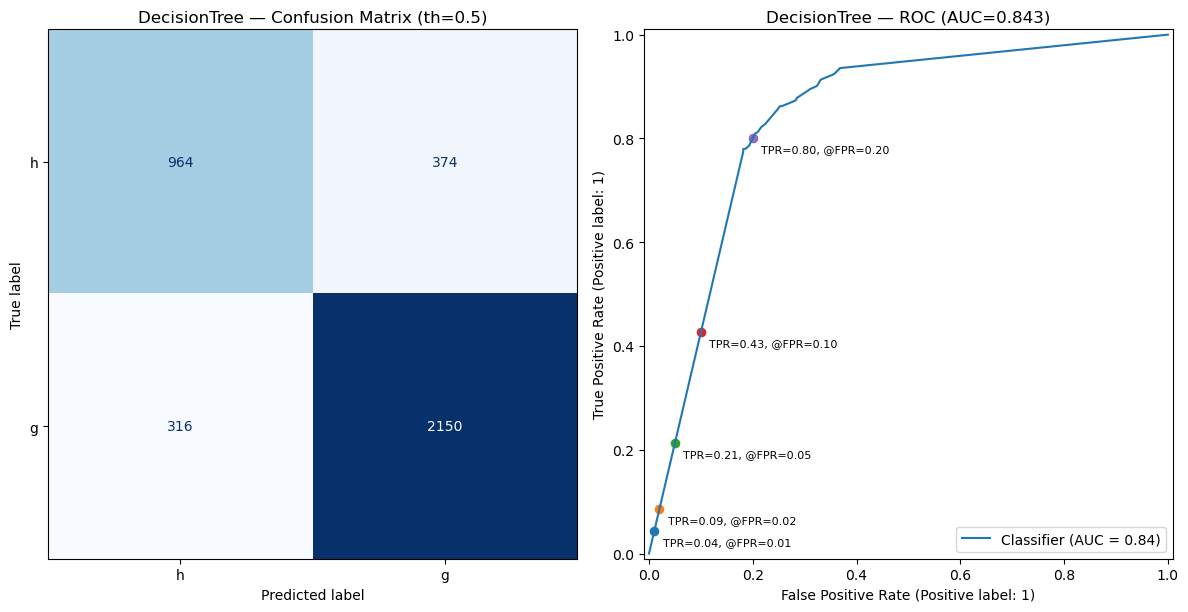

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== RandomForest: treating 'g' as POSITIVE (signal) ===
CV best (partial AUC @ FPR ≤ 0.10): 0.9021
Best parameters:
  n_estimators: 50
  min_samples_split: 10
  min_samples_leaf: 1
  max_features: log2
  max_depth: 50

Test-set metrics:
AUC (full): 0.9346
partial AUC @ FPR ≤ 0.01: 0.6066
partial AUC @ FPR ≤ 0.02: 0.6376
partial AUC @ FPR ≤ 0.05: 0.7042
partial AUC @ FPR ≤ 0.10: 0.7706
partial AUC @ FPR ≤ 0.20: 0.8429
TPR @ FPR = 0.01: 0.2770
TPR @ FPR = 0.02: 0.4169
TPR @ FPR = 0.05: 0.5860
TPR @ FPR = 0.10: 0.7753
TPR @ FPR = 0.20: 0.9298

Confusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:
      h     g
h  1064   274
g   167  2299


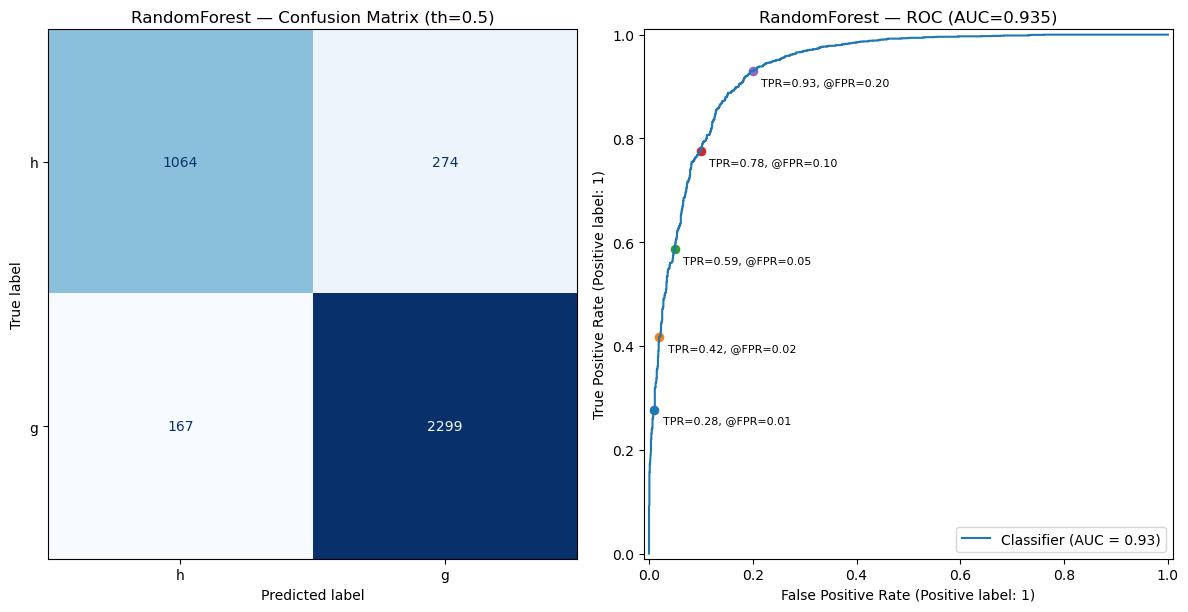

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== SVM_RBF: treating 'g' as POSITIVE (signal) ===
CV best (partial AUC @ FPR ≤ 0.10): 0.7889
Best parameters:
  gamma: 0.1
  C: 100

Test-set metrics:
AUC (full): 0.9317
partial AUC @ FPR ≤ 0.01: 0.6166
partial AUC @ FPR ≤ 0.02: 0.6493
partial AUC @ FPR ≤ 0.05: 0.7019
partial AUC @ FPR ≤ 0.10: 0.7697
partial AUC @ FPR ≤ 0.20: 0.8401
TPR @ FPR = 0.01: 0.3398
TPR @ FPR = 0.02: 0.3913
TPR @ FPR = 0.05: 0.5965
TPR @ FPR = 0.10: 0.7968
TPR @ FPR = 0.20: 0.9108

Confusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:
      h     g
h  1065   273
g   208  2258


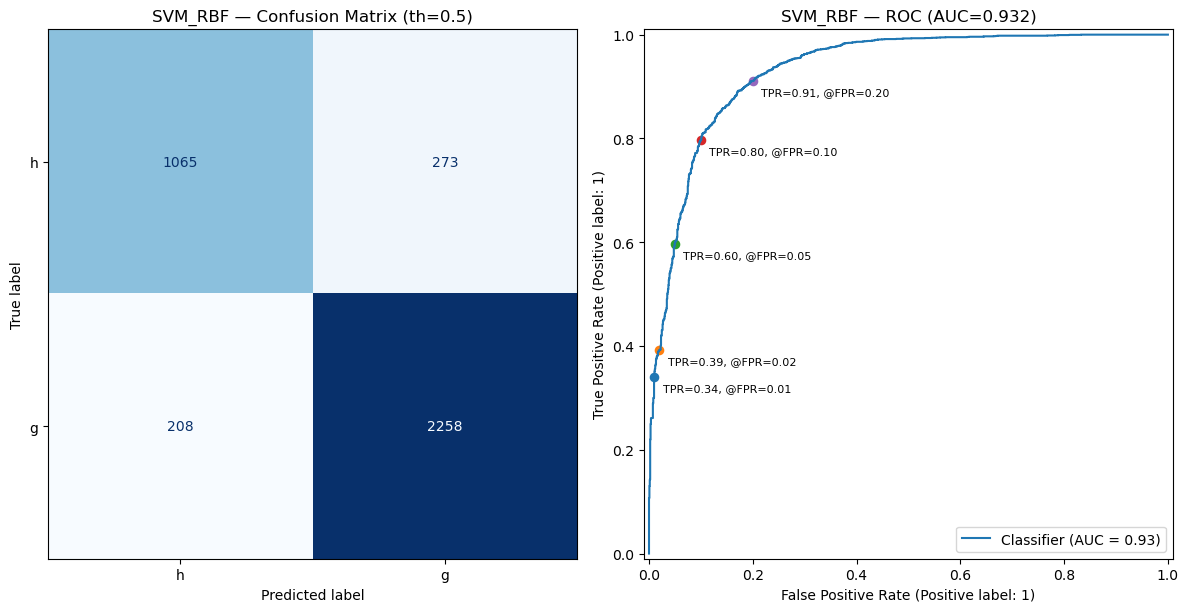

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== GBDT: treating 'g' as POSITIVE (signal) ===
CV best (partial AUC @ FPR ≤ 0.10): 0.8592
Best parameters:
  subsample: 1.0
  n_estimators: 200
  max_features: log2
  max_depth: 5
  learning_rate: 0.1

Test-set metrics:
AUC (full): 0.9378
partial AUC @ FPR ≤ 0.01: 0.6261
partial AUC @ FPR ≤ 0.02: 0.6508
partial AUC @ FPR ≤ 0.05: 0.7070
partial AUC @ FPR ≤ 0.10: 0.7774
partial AUC @ FPR ≤ 0.20: 0.8477
TPR @ FPR = 0.01: 0.3118
TPR @ FPR = 0.02: 0.3852
TPR @ FPR = 0.05: 0.6164
TPR @ FPR = 0.10: 0.7960
TPR @ FPR = 0.20: 0.9290

Confusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:
      h     g
h  1088   250
g   200  2266


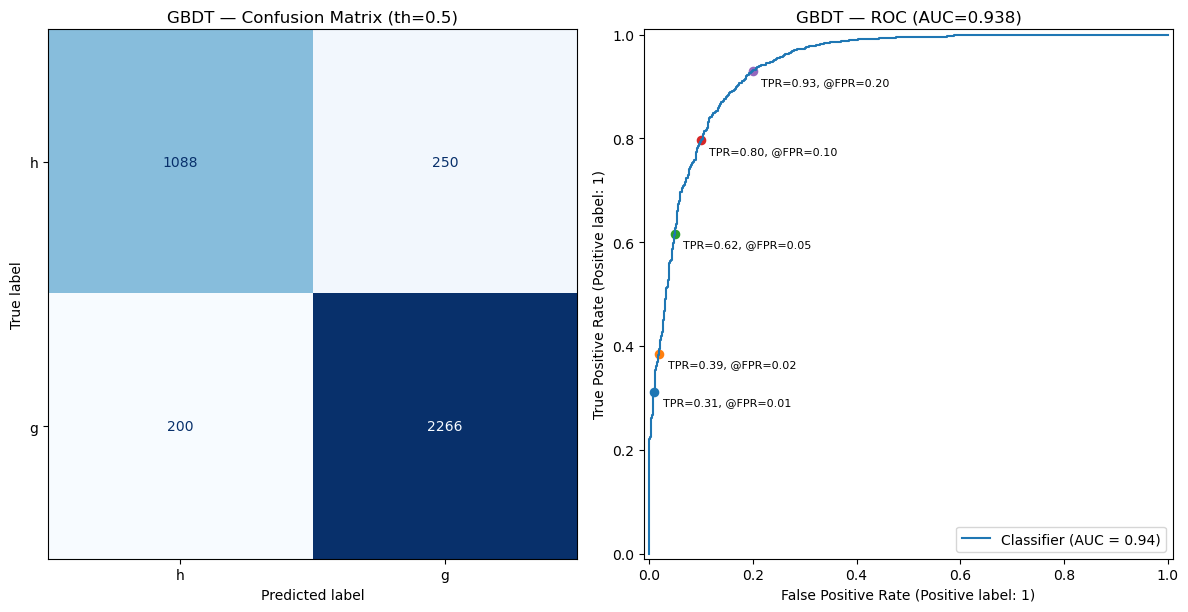

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== MLP: treating 'g' as POSITIVE (signal) ===
CV best (partial AUC @ FPR ≤ 0.10): 0.8220
Best parameters:
  learning_rate_init: 0.01
  hidden_layer_sizes: (128, 64)
  batch_size: 128
  alpha: 0.0001
  activation: tanh

Test-set metrics:
AUC (full): 0.9217
partial AUC @ FPR ≤ 0.01: 0.5956
partial AUC @ FPR ≤ 0.02: 0.6345
partial AUC @ FPR ≤ 0.05: 0.6927
partial AUC @ FPR ≤ 0.10: 0.7437
partial AUC @ FPR ≤ 0.20: 0.8165
TPR @ FPR = 0.01: 0.2875
TPR @ FPR = 0.02: 0.3942
TPR @ FPR = 0.05: 0.5418
TPR @ FPR = 0.10: 0.6873
TPR @ FPR = 0.20: 0.8982

Confusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:
      h     g
h  1108   230
g   316  2150


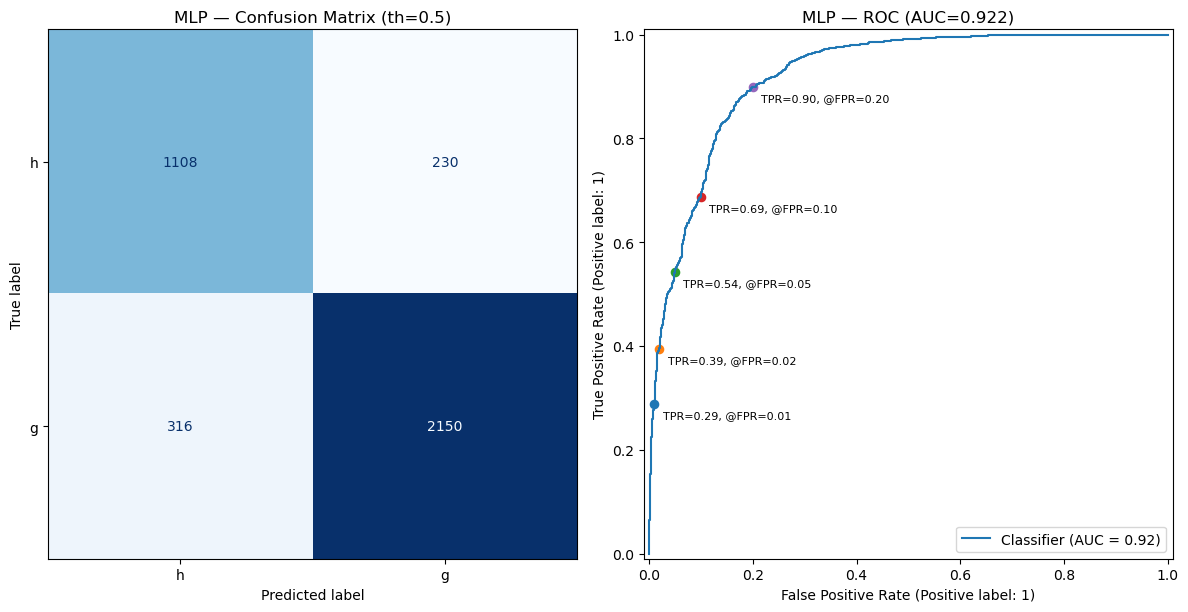

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== XGBoost: treating 'g' as POSITIVE (signal) ===
CV best (partial AUC @ FPR ≤ 0.10): 0.8613
Best parameters:
  subsample: 0.8
  reg_lambda: 10
  reg_alpha: 0.01
  n_estimators: 300
  min_child_weight: 1
  max_depth: 5
  learning_rate: 0.1
  gamma: 0
  colsample_bytree: 0.8

Test-set metrics:
AUC (full): 0.9411
partial AUC @ FPR ≤ 0.01: 0.6288
partial AUC @ FPR ≤ 0.02: 0.6600
partial AUC @ FPR ≤ 0.05: 0.7177
partial AUC @ FPR ≤ 0.10: 0.7853
partial AUC @ FPR ≤ 0.20: 0.8556
TPR @ FPR = 0.01: 0.3394
TPR @ FPR = 0.02: 0.4303
TPR @ FPR = 0.05: 0.6192
TPR @ FPR = 0.10: 0.8216
TPR @ FPR = 0.20: 0.9351

Confusion matrix (threshold=0.5, test set) [rows=True label, cols=Predicted]:
      h     g
h  1099   239
g   197  2269


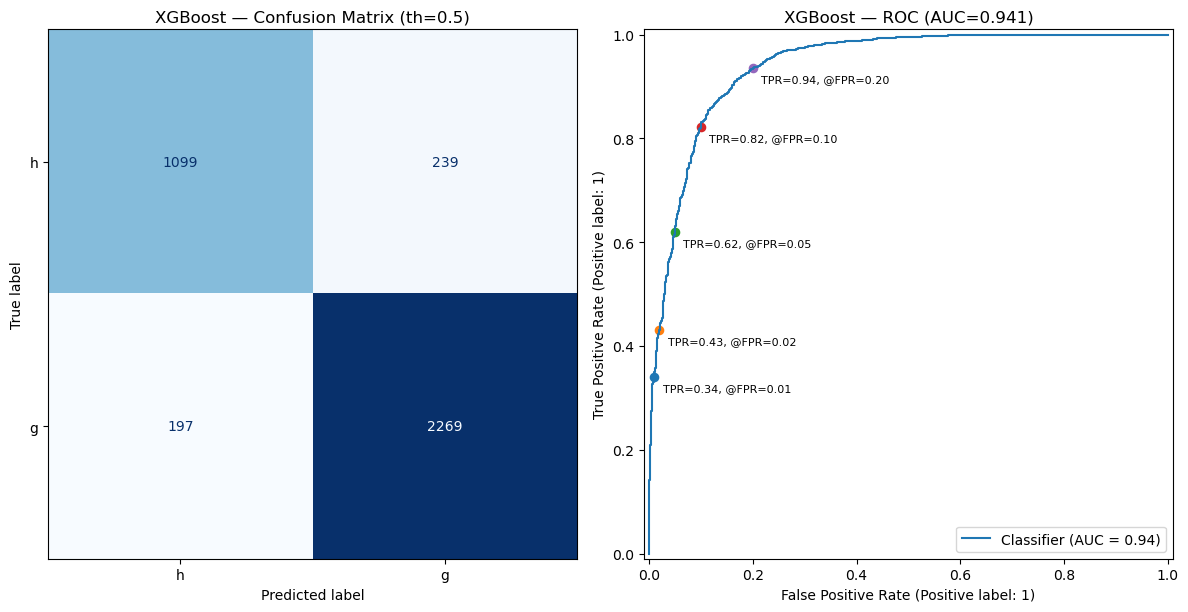

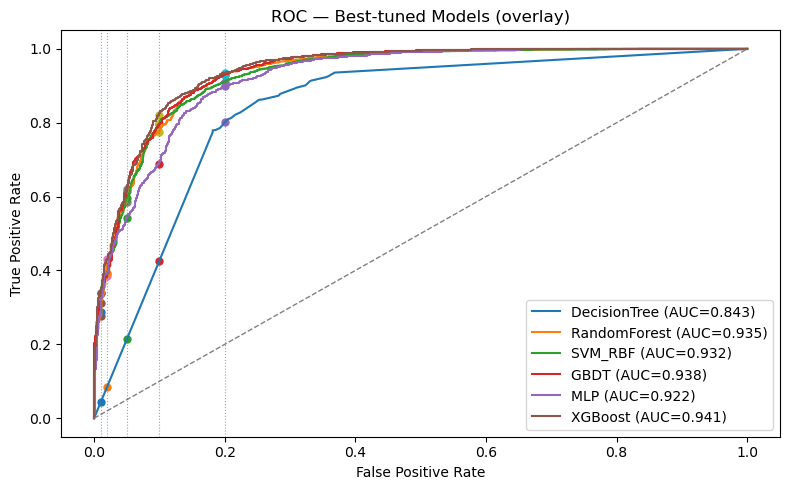


TPR at target FPRs (test set) — higher is better
╒══════════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤══════════════╕
│ Model        │   CV pAUC@≤0.10 │   TPR@FPR=0.01 │   TPR@FPR=0.02 │   TPR@FPR=0.05 │   TPR@FPR=0.10 │   TPR@FPR=0.20 │   AUC (full) │
╞══════════════╪═════════════════╪════════════════╪════════════════╪════════════════╪════════════════╪════════════════╪══════════════╡
│ RandomForest │          0.9021 │         0.2770 │         0.4169 │         0.5860 │         0.7753 │         0.9298 │       0.9346 │
├──────────────┼─────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼──────────────┤
│ XGBoost      │          0.8613 │         0.3394 │         0.4303 │         0.6192 │         0.8216 │         0.9351 │       0.9411 │
├──────────────┼─────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼──────────────┤
│ GBD

In [4]:
# --------------------- run ---------------------
suite = ROCFocusedClassifierSuite(
    X_train, y_train, X_test, y_test,
    positive_label="g",  # gamma = signal (pos=1)
    n_iter=10,            # quick search; increase for deeper tuning
    cv_splits=5,
    random_state=42,
    verbose=1
)
summary_df = suite.run_and_report()
